# Task 3: Customer Segmentation / Clustering

# Steps for Customer Segmentation:

Step 1: Load the Datasets

We will start by loading the required datasets: Customers.csv for customer profile data and Transactions.csv for transaction details.

In [2]:
import pandas as pd

# Load the datasets
customers = pd.read_csv('Customers.csv')  
transactions = pd.read_csv('Transactions.csv') 


Step 2: Data Preprocessing and Feature Engineering

To perform clustering, we need to merge both datasets and then transform the data into a format suitable for clustering.

In [3]:
# Merge the customers data with transaction data on CustomerID
merged_data = transactions.merge(customers, on='CustomerID', how='left')

In [6]:
#check the available columns
print(merged_data.columns)

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')


In [9]:
# Step 1: Feature Engineering
# Aggregate data at the customer level based on available features
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  # Total and average transaction value
    'Quantity': 'sum',  # Total quantity purchased
    'Price': 'mean',  # Average price of products purchased
}).reset_index()

# Flatten multi-level columns
customer_features.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'TotalQuantity', 'AvgPrice']

# Merge with customer profile (Region)
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Convert categorical features like 'Region' to dummy variables (one-hot encoding)
customer_features = pd.get_dummies(customer_features, columns=['Region'])


In [10]:
# Step 2: Standardize Numeric Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_features = ['TotalSpend', 'AvgSpend', 'TotalQuantity', 'AvgPrice']
customer_features[numeric_features] = scaler.fit_transform(customer_features[numeric_features])

In [12]:
# Step 3: Apply Clustering (K-Means)
from sklearn.cluster import KMeans

# List of columns to use for clustering (numeric features + region dummy columns)
clustering_columns = numeric_features + [col for col in customer_features.columns if 'Region_' in col]

# Set number of clusters between 2 and 10 (let's use 4 clusters for example)
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[clustering_columns])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
# Step 4: Evaluate Clustering (DB Index)
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(customer_features[clustering_columns], customer_features['Cluster'])
print("Davies-Bouldin Index: ", db_index)

Davies-Bouldin Index:  1.2199294204104287


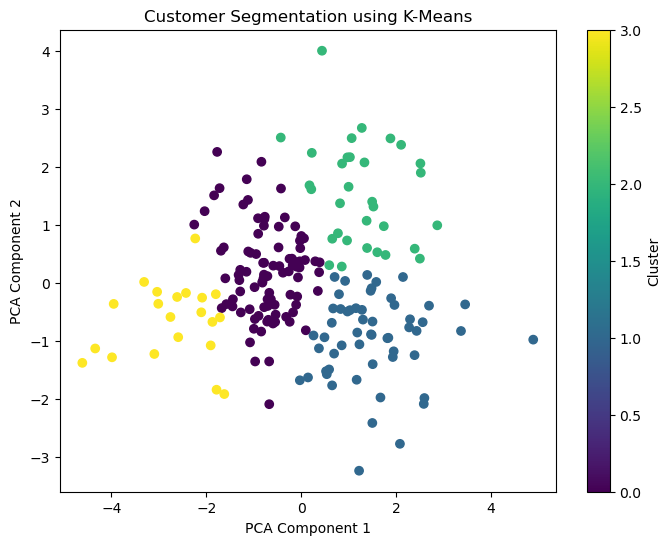

In [16]:
# Step 5: Visualize Clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (PCA to 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features[clustering_columns])

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features['Cluster'], cmap='viridis', label='Cluster')
plt.title('Customer Segmentation using K-Means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [20]:
# Step 6: Save the Segmented Data to CSV
customer_features[['CustomerID', 'Cluster']].to_csv('Rupa_Veerala_Segmented_Customers(Clustering).csv', index=False)